In [38]:
import mne
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
matplotlib.rcParams.update({'font.size': 15})
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from mne.decoding import Vectorizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA, FastICA

from sklearn.metrics import confusion_matrix
import itertools

import os

In [39]:
"""
GOAL: Use all data for language and non-language (not restrited to visual)
      Optimize RandomForest paramter using GridSearchCV
      
      
"""

'\nGOAL: Use all data for language and non-language (not restrited to visual)\n      Optimize RandomForest paramter using GridSearchCV\n      \n      \n'

In [40]:
def importantChannelFinder(features,target,binary_epoch):
    forest = RandomForestClassifier(n_estimators=100,random_state=0)
    
    #cv = StratifiedKFold(n_splits=1,shuffle=True)
    scores = []
 
    
    X_train,X_test,y_train,y_test = train_test_split(features,target,test_size=0.30, random_state=42)
      
    twoD_X_train = Vectorizer().fit_transform(X_train)
    
    forest.fit(twoD_X_train,y_train)

    """manipulate array to 125 features"""
    impt = []
    for e in forest.feature_importances_:
        impt.append(e)
        
    #print("shape of important feat array: ",np.array(impt).shape)
    feat_importnt_allchannels = []
    time = binary_epoch.get_data().shape[2]
    channel_times_time = binary_epoch.get_data().shape[1] * binary_epoch.get_data().shape[2]
    for i in range(0,32125,257):
        #print(i)
        hold = []
        for j in range(i,i+time):
            hold.append(impt[j])

        feat_importnt_allchannels.append(hold)
        
    print(np.array(feat_importnt_allchannels).shape)  
    

    
#     twoD_X_test = Vectorizer().fit_transform(X_test)
    

#     #preds.append(clf.predict(twoD_X_test))
#     #print('shape of y_test is: ',np.array(y_test).shape)
#     #print(np.array(preds).shape)
#     #d = np.transpose(preds).ravel()
#     #print('shape of pred is: ',d.shape)

#     print('Accuracy on training set {:.3f}'.format(forest.score(twoD_X_train,y_train)))
#     print('Accuracy on test set {:.3f}'.format(forest.score(twoD_X_test,y_test)))
#     #scores.append(clf.score(twoD_X_test,y_test))

# #     target_names = ['Visual', 'Audio']


# #     report = classification_report(y_test, d, target_names=target_names)
# #     print(report)
        
# #     print('standard deviation of scores: ',np.std(scores))    
# #     return np.mean(scores)
     
    binary_epoch_copy = binary_epoch.copy()
    info = binary_epoch.info
    binary_epoch_twoD = Vectorizer().fit_transform(binary_epoch_copy.get_data())
    evoked = mne.EvokedArray(feat_importnt_allchannels, info, tmin=binary_epoch.times[0])
    joint_kwargs = dict(ts_args=dict(time_unit='s'),
                        topomap_args=dict(time_unit='s'))
    evoked.plot_joint(times=np.arange(0., .500, .100), title='patterns',
                      **joint_kwargs)

In [41]:
def do(epoch):
    #epoch = mne.read_epochs(p,preload=True)
    epoch.drop_channels(ch_names=[ 'LL4', 'L12'])
    epoch.drop_channels(ch_names=[ 'Nasium', 'VEOG'])
#     print('dropped channels LL4,L12,NASIUM,VEOG')
    
    epoch_copy = epoch.copy()
#    print(epoch_copy.events)
#     print(epoch_copy.event_id)
    
    for event in epoch_copy.events:
        #print(event[-1])
        if (event[-1] == 912) | (event[-1] == 1212) | (event[-1] == 1012) | (event[-1] == 1112):
            event[-1] = 100
            
        elif (event[-1] == 112) | (event[-1] == 412) | (event[-1] == 212) | (event[-1] == 312):
            event[-1] = 200  
    
    binary_epoch = epoch_copy[(epoch_copy.events[:,-1]==100) | (epoch_copy.events[:,-1]==200)].copy()
    #print(binary_epoch.events)
    
    #print(binary_epoch.info)
    """
    Classify filtered data and check results
    """
    features = binary_epoch.get_data()
    print('shape of features:',features.shape)
    target = binary_epoch.events[:,-1]
    print('shape of target:',target.shape)
    
    importantChannelFinder(features,target,binary_epoch)

In [42]:
def SubjFolderSearch(path):
    subjFolders = os.listdir(path)
    AllFiles = []
    for i in subjFolders:
        if '.DS_Store' not in i:
            AllFiles.append(os.path.join(path,i))
    
    
    return AllFiles

In [43]:
path = '/sharedData3/proj_mdg/scratch-eproj/LARGE_EPOCH_OBJECTS/large_epoch_1_epo.fif'
#AllSetFiles = SubjFolderSearch(path)
#print(AllSetFiles)

epo = mne.read_epochs(path)



Reading /sharedData3/proj_mdg/scratch-eproj/LARGE_EPOCH_OBJECTS/large_epoch_1_epo.fif ...
    Found the data of interest:
        t =       0.00 ...     500.00 ms
        0 CTF compensation matrices available
8103 matching events found
Applying baseline correction (mode: mean)
Reading /sharedData3/proj_mdg/scratch-eproj/LARGE_EPOCH_OBJECTS/large_epoch_1_epo-1.fif ...
    Found the data of interest:
        t =       0.00 ...     500.00 ms
        0 CTF compensation matrices available
8103 matching events found
Applying baseline correction (mode: mean)
16206 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


shape of features: (10587, 125, 257)
shape of target: (10587,)
(125, 257)


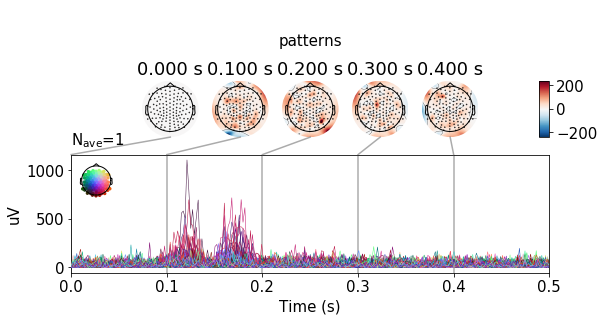

In [44]:
do(epo)